# Task 1 - CPA Prediction

In this notebook I will go through the process for both creating the machine learning model to preddict the cost-per-application (**CPA**) as well as the decision-making algorithm for a new campaign. 

Later I will provide a first draft of a selection algorithm.

Let's start with a quick look at the data.

In [182]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

from sklearn.preprocessing import TargetEncoder, OneHotEncoder
from dataclasses import dataclass

In [183]:
df = pd.read_csv(
        "../resources/data/ds_challenge_data.csv",
        dtype={
            "campaign_id": str,
            "category_id": str,
            "industry": str,
            "customer_id": str,
            "publisher": str, # hexadecimal number, but str suits our purposes.
            "market_id": str,
            "cost": float,
            "clicks": float, # Should be integer but cannot safely convert. We round and convert later
            "converions": int
        },
        parse_dates=["date"]
    )

# Rename due to typo
df.rename(columns={"converions": "conversions"}, inplace=True)

In [184]:
df.head()

,date,campaign_id,category_id,industry,customer_id,publisher,market_id,cost,clicks,conversions
0,2020-01-13,13438542,291000,Health Science,746,2c493,12733593,0.550000,1.000000,0
1,2020-03-14,13263546,413000,Marketing,564,cd0ec,12705087,1.240000,3.000001,0
2,2019-12-26,13582620,532000,"Transportation, Distribution & Logistics",629,d7fa7,12705063,4.184004,12.000011,0
3,2020-01-29,14050177,172070,Manufacturing,185,2b764,12705063,1.590002,4.000005,0
4,2019-12-06,12946962,131000,Finance,288,28377,12705087,1.037769,1.000001,0


Here we can  se the **clicks** are a **float**. I assume this is an issue with the data since normally clicks as integers. **Let's recast is to an integer.**

In [185]:
# Convert clicks to integer
df["clicks"] = df["clicks"].round().astype(int)

Text(0.5, 1.0, 'Conversions Distribution')

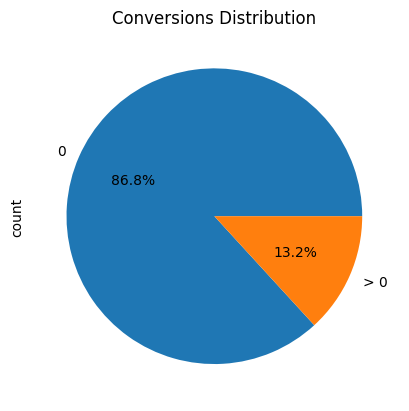

In [186]:
(df.conversions > 0).value_counts().plot(kind="pie", labels=["0", "> 0"], autopct="%1.1f%%")
plt.title("Conversions Distribution")


In [187]:
df.head()

,date,campaign_id,category_id,industry,customer_id,publisher,market_id,cost,clicks,conversions
0,2020-01-13,13438542,291000,Health Science,746,2c493,12733593,0.550000,1,0
1,2020-03-14,13263546,413000,Marketing,564,cd0ec,12705087,1.240000,3,0
2,2019-12-26,13582620,532000,"Transportation, Distribution & Logistics",629,d7fa7,12705063,4.184004,12,0
3,2020-01-29,14050177,172070,Manufacturing,185,2b764,12705063,1.590002,4,0
4,2019-12-06,12946962,131000,Finance,288,28377,12705087,1.037769,1,0


In [188]:
df[df.conversions > df.clicks]

,date,campaign_id,category_id,industry,customer_id,publisher,market_id,cost,clicks,conversions
15,2019-11-08,13195145,413000,Marketing,564,2c493,12705063,0.000000,0,1
25,2020-01-30,13323932,131000,"Science, Technology, Engineering & Mathematics",694,2c493,12764912,0.000000,0,4
40,2019-12-07,13196132,413000,Marketing,564,28b5f,12764913,0.000000,0,1
59,2020-01-31,13196326,413000,Marketing,564,cf11d,12693343,0.000000,0,1
111,2020-03-18,14004103,171000,Marketing,564,cd0ec,12692598,0.000000,0,1
...,...,...,...,...,...,...,...,...,...,...
43798,2020-03-06,13226140,413000,Marketing,564,cf11d,12729555,0.759637,1,3
43802,2019-11-25,13214013,131000,Finance,288,2c493,12734520,0.000000,0,1
43811,2020-03-31,13195688,413000,Marketing,564,28b5f,12729556,0.000000,0,1
43834,2020-03-24,13195991,419000,Marketing,564,2c493,12729555,1.245817,1,2


**Something is strange here**. We have some data where we have conversions but we have no clicks. This looks like bad data so I will drop this.

In [189]:
# Remove bad data
df = df[df.conversions < df.clicks] # More conversions than clicks is not possible

## Temporal Data

We have temporal data, where each row basically represents the performance of the campaign for each specific date. This means that we have **duplicate** campaigns (for different dates). An aggregation seems prudent here because we want to predict the overall performance of the campaign and not for a specific date.

In [190]:
df = df.groupby([
    "campaign_id",
    "category_id",
    "industry",
    "customer_id",
    "publisher",
    "market_id"
]).agg({
    "cost": "sum",
    "clicks": "sum",
    "conversions": "sum"
}).reset_index()

In [191]:
print(f"We are left with {df.shape[0]} rows.")

We are left with 40853 rows.


## Dealing with CPA and division by zero

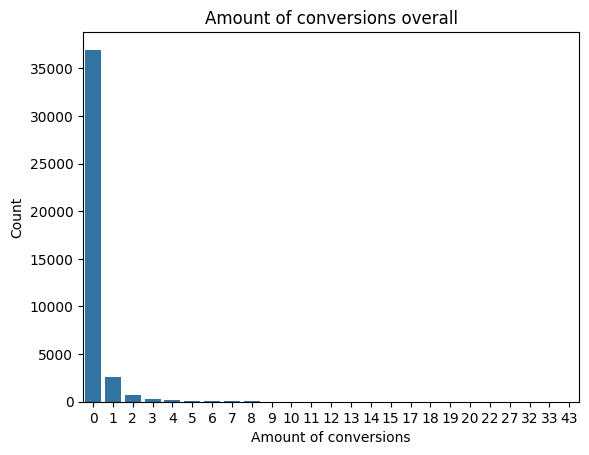

In [192]:
# TODO: put here that we have many zeroes and than, to predict the CPA, we have to deal with these zeroes since we cant div by zero
sns.countplot(df, x="conversions")
plt.title('Amount of conversions overall')
plt.xlabel('Amount of conversions')
plt.ylabel('Count')
plt.show()

We have quite a lot of zeros. This is a problem for the future CPA prediction. Why? If Cost Per Application is defined by: $ \text{CPA} = \frac{\text{Cost}}{\# \text{Applications}} $, then we have a problem if a campaign has zero conversions. $ \text{CPA} = \frac{\text{Cost}}{\# \text{Applications}} = inf $. A linear model is not able to deal with this so we have to find a way to deal with it.

There are a few ways:

- $ CPA = Cost $ --> There are a few problems with this. This will imply that we have 1 conversion and the $ CPA = OverallCost. $. This might confuse the model, especially when our conversions variable is very unballanced.

- $ CPA = \frac{\text{Cost}}{\epsilon} $ --> Same as above, but we are still injecting synthetics labels that are misleading.

- Filter out $ conversions=0 $ --> There is no label distortion but we might be creating some bias and ignoring a lot of data.

At the end the best option would be to make this a double model.

1. A **conversion classifier**: *Will the campaign produce conversions?*

This model will predict whether that campaign will result in positive conversions or no conversions at all. This will be trained on the whole data.

2. A **CPA regressor**: *How much will the CPA be?*

This model will predict the actual CPA, if the first model will predict conversions for a specific campaign. This will be trained on data where there is at least 1 conversion.


---

To make things simple, I will assign the $ cost $ as the CPA, if there are no conversions. Deleting all the $ conversions = 0 $ does not seem feasible due to schrinkage of about **90%** the of the total data. Dropping those rows will hurt more than using the $ cost $ as a CPA.

We will do something similar when creating the CPC (Cost per click)

In [193]:
print(f"The number of training samples has decreased to {df.shape[0]}")

The number of training samples has decreased to 40853


In [194]:
# If conversions is zero, then CPC = Cost
df["CPC"] = df.apply(lambda x: x["cost"] if x["conversions"] == 0 else x["cost"] / x["conversions"] ,axis=1) 

# If conversions is zero, then CPA = Cost
df["CPA"] = df.apply(lambda x: x["cost"] if x["clicks"]==0 else x["cost"] / x["clicks"], axis=1)

In [195]:
df.sample(5)

,campaign_id,category_id,industry,customer_id,publisher,market_id,cost,clicks,conversions,CPC,CPA
33880,14009308,419000,Marketing,564,d7fa7,12698428,0.570861,1,0,0.570861,0.570861
17889,13263889,419000,Marketing,564,2b764,12771255,0.421631,1,0,0.421631,0.421631
4185,13194028,412000,Marketing,564,2c493,12763724,2.704166,8,0,2.704166,0.338021
10040,13195575,412000,Marketing,564,28b5f,12691098,0.377482,1,0,0.377482,0.377482
12361,13196204,413000,Marketing,564,2c493,12763602,2.999658,9,0,2.999658,0.333295


## CPA Distribution

<Axes: xlabel='CPA', ylabel='Density'>

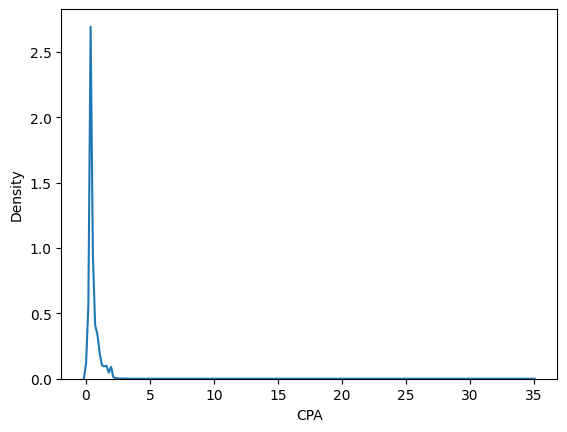

In [200]:
sns.kdeplot(df.CPA)

The CPA is **highly skewed** and will give quite some trouble to our model. We would rather have something close to a normal distribution. A common way is to transform the label. I'll use **log1p** ($ log(1+x) $)

<Axes: xlabel='CPA', ylabel='Density'>

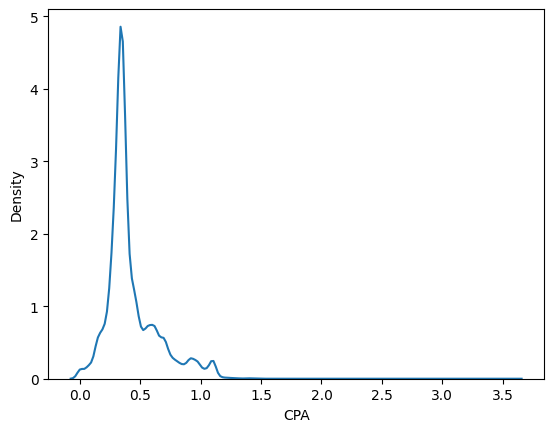

In [201]:
sns.kdeplot(np.log1p(df.CPA))

This looks much better. We will leave like this and revert it to actual CPA after the prediction.

In [202]:
# Transforming the label
df["CPA_transformed"] = np.log1p(df["CPA"])

## Additional Descriptive Statistics


In [203]:
publishers = df.groupby("publisher").agg(
    avg_clicks=("clicks", "mean"),
    avg_conversions=("conversions", "mean"),
    n_campaigns=("publisher", "count"),
    avg_campaign_cost=("cost", "mean"),
    total_historical_cost=("cost", "sum"),
    total_historical_applications=("conversions", "sum"),
    total_historical_clicks=("clicks", "sum")
)

publishers["historical_cpa"] = publishers.total_historical_cost / publishers.total_historical_applications
publishers["historical_cpc"] = publishers.total_historical_cost / publishers.total_historical_clicks
publishers["historical_conversion_rate"] = publishers.total_historical_applications / publishers.total_historical_clicks

publishers.sort_values(by="historical_cpa")

,avg_clicks,avg_conversions,n_campaigns,avg_campaign_cost,total_historical_cost,total_historical_applications,total_historical_clicks,historical_cpa,historical_cpc,historical_conversion_rate
publisher,,,,,,,,,,
28b5f,2.411741,0.183857,2453,2.254419,5530.089696,451,5916,12.261840,0.934768,0.076234
cf11d,9.153611,0.286206,2617,5.103185,13355.036194,749,23955,17.830489,0.557505,0.031267
cd0ec,10.326129,0.268972,2082,5.306307,11047.732067,560,21499,19.728093,0.513872,0.026048
2c493,14.420956,0.340751,10336,6.878345,71094.573020,3522,149055,20.185853,0.476969,0.023629
60195,2.359901,0.079208,2020,2.081670,4204.972508,160,4767,26.281078,0.882100,0.033564
d7fa7,4.058633,0.089928,5560,2.451408,13629.828636,500,22566,27.259657,0.603998,0.022157
90dc2,5.508681,0.125000,576,3.641090,2097.267567,72,3173,29.128716,0.660973,0.022691
2b764,4.050327,0.099263,7193,2.942925,21168.458869,714,29134,29.647701,0.726590,0.024507
8c421,7.361827,0.172131,854,5.148184,4396.549332,147,6287,29.908499,0.699308,0.023382


In [204]:
def plot_best(group_cols: list[str], specific_col: str = None) -> None:
    assert specific_col in ["conversion_rate", "cpa"] or specific_col is None
    cols_to_drop = ["conversions", "clicks", "cost"]

    if specific_col=="conversion_rate":
        cols_to_drop += ["cpa"]
    elif specific_col=="cpa":
        cols_to_drop += ["conversion_rate"]

    (
        df.groupby(group_cols)
        .agg({"clicks": "sum", "conversions": "sum", "cost": "sum"})
        .assign(conversion_rate=lambda x: x["clicks"] / x["conversions"])
        .assign(cpa=lambda x: x["cost"] / x["conversions"])
        .sort_values(by=specific_col or "cpa", ascending=True)
        .head(20)
        .drop(columns=cols_to_drop)
        .plot(kind="barh", figsize=(8, 8))
    )
    plt.title(f"{specific_col if specific_col else 'Conversion Rate and CPA'} by {group_cols}")

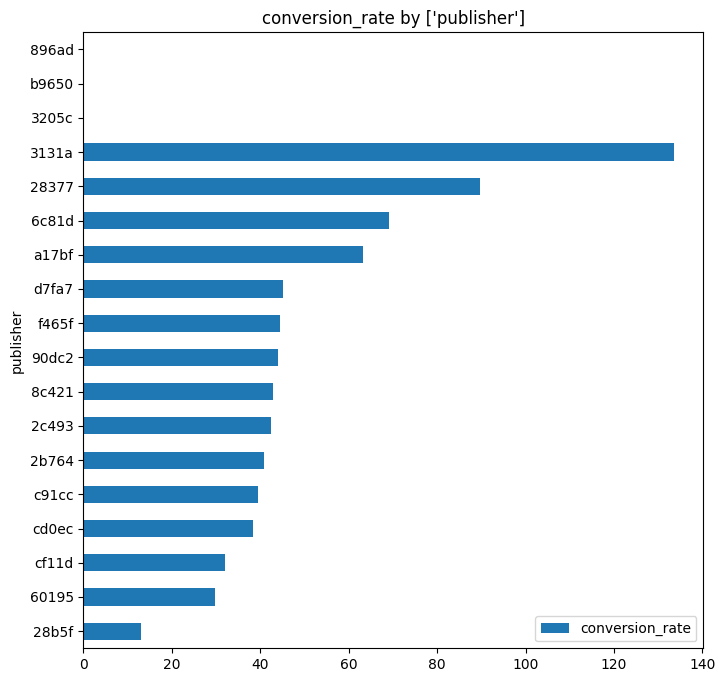

In [205]:
plot_best(["publisher"], specific_col="conversion_rate")

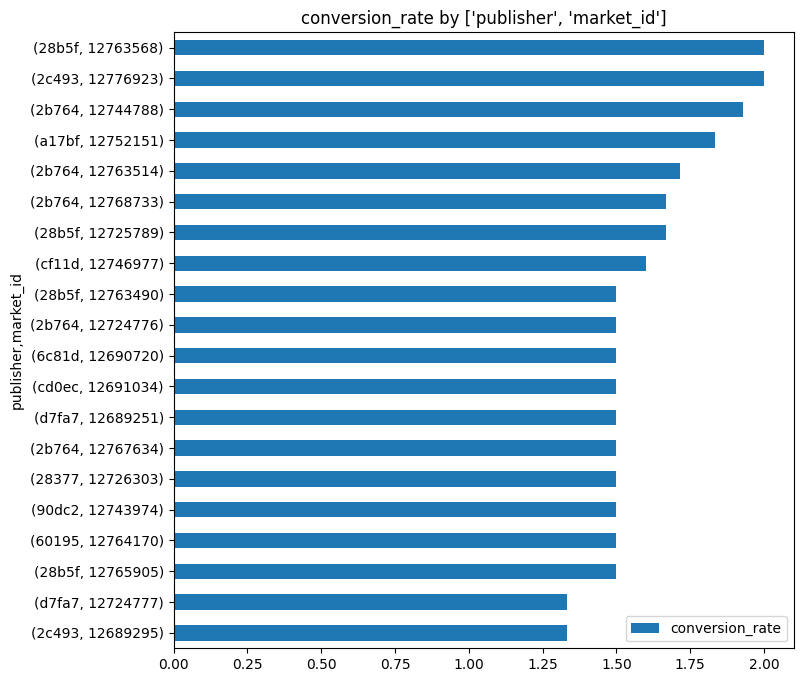

In [206]:
plot_best(["publisher", "market_id"], specific_col="conversion_rate")

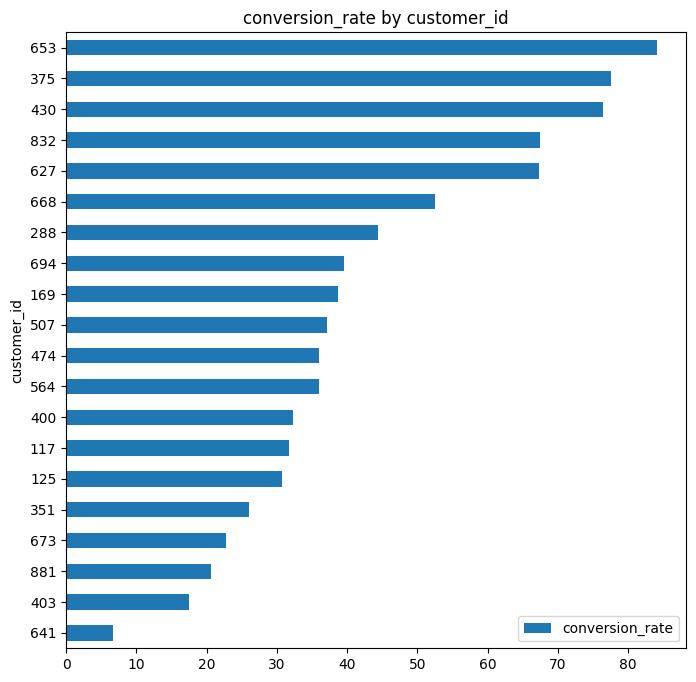

In [207]:
plot_best("customer_id", specific_col="conversion_rate")

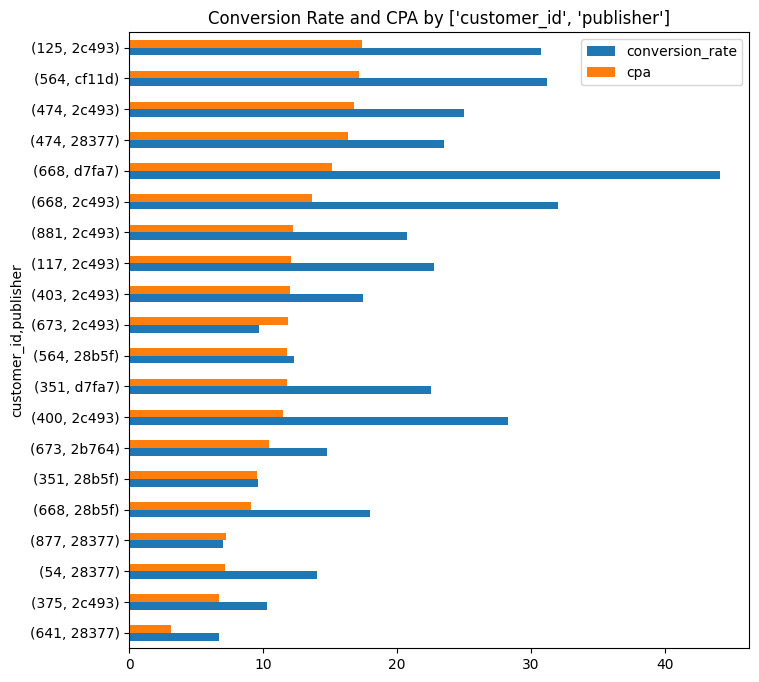

In [208]:
plot_best(["customer_id", "publisher"])

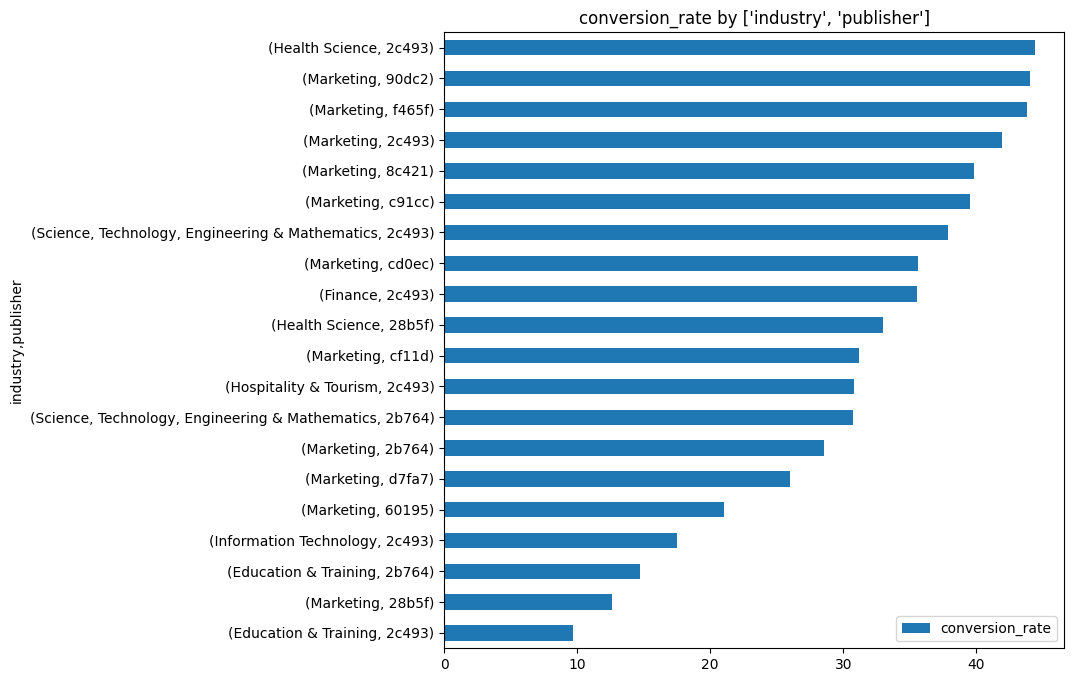

In [209]:
plot_best(["industry", "publisher"], specific_col="conversion_rate")

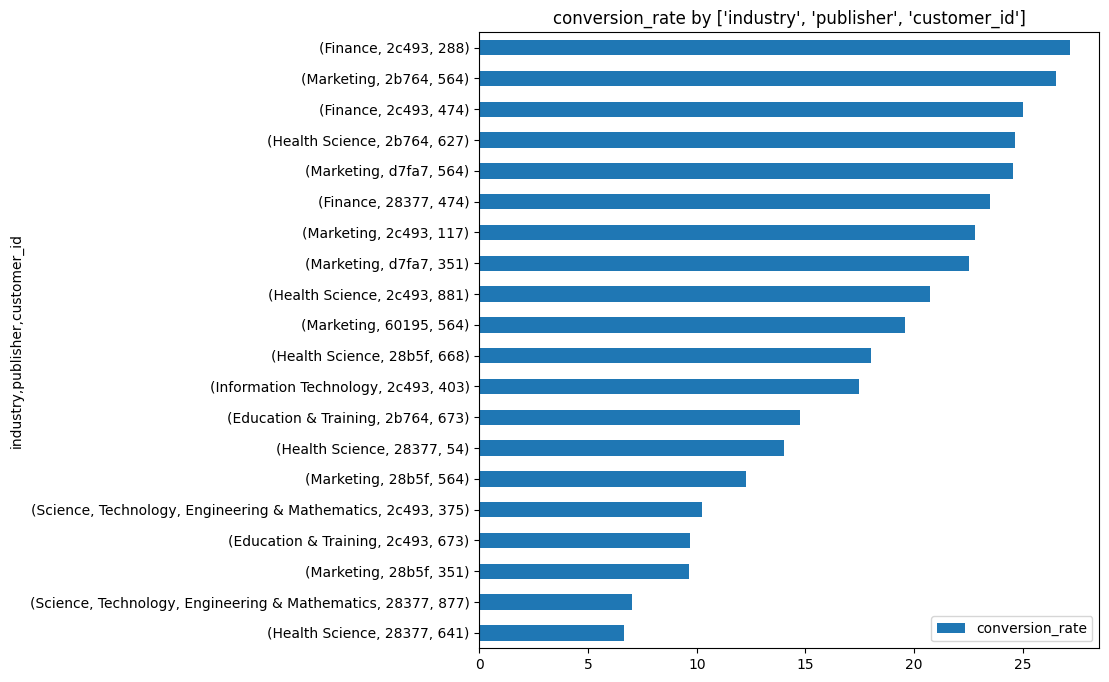

In [210]:
plot_best(["industry", "publisher", "customer_id"], specific_col="conversion_rate")

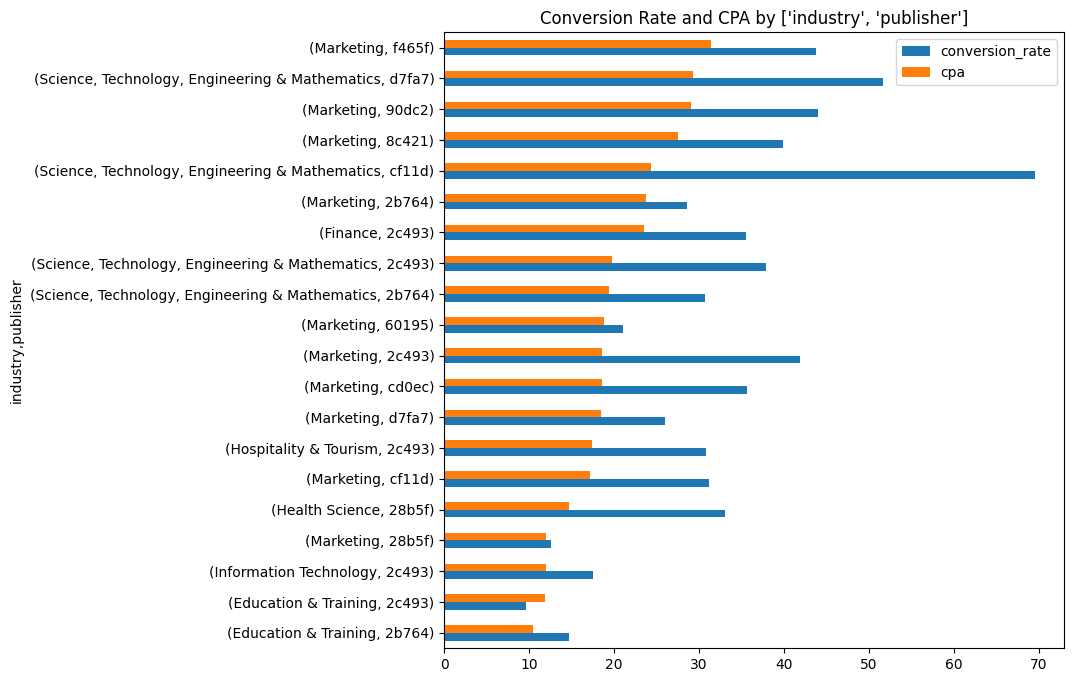

In [211]:
plot_best(["industry", "publisher"])

## Training

### Encoding the Categorical Variables

In [138]:
df

,campaign_id,category_id,industry,customer_id,publisher,market_id,cost,clicks,conversions,CPC,CPA,CPA_transformed
0,12595492,419000,Health Science,668,2b764,12690930,3.068494,3,0,3.068494,1.022831,0.704498
1,12595620,291060,Health Science,668,d7fa7,12686175,6.791963,20,0,6.791963,0.339598,0.292370
2,12595628,291060,Health Science,668,28377,12765338,4.024980,6,0,4.024980,0.670830,0.513320
3,12595628,291060,Health Science,668,d7fa7,12746970,0.896988,1,0,0.896988,0.896988,0.640267
4,12595739,419000,Health Science,668,60195,12719161,1.566743,2,0,1.566743,0.783371,0.578506
...,...,...,...,...,...,...,...,...,...,...,...,...
40848,15059459,412000,Finance,287,28377,12702556,9.985565,13,0,9.985565,0.768120,0.569917
40849,15061377,100000,Finance,288,2b764,12691709,2.083873,2,0,2.083873,1.041937,0.713899
40850,15069416,291000,Health Science,746,2c493,12727601,4.010148,2,0,4.010148,2.005074,1.100302
40851,15069490,291000,Health Science,746,2c493,12765342,18.062285,11,1,18.062285,1.642026,0.971546


In [139]:
print_unique = lambda col: print(f"Unique values of {col}: {df[col].nunique()}")

[print_unique(col) for col in ["category_id", "industry", "customer_id", "publisher", "market_id"]]

Unique values of category_id: 40
Unique values of industry: 12
Unique values of customer_id: 30
Unique values of publisher: 18
Unique values of market_id: 2659


[None, None, None, None, None]

The **market_id** has quite a **high cardinality**. For this one we will use a **TargetEncoder**, which is known to handle well high-cardinality categorical variables. For the others, a one-hot encoding is enough.

### Fitting to the data

In [140]:
# Setting up the columns

onehot_cols = ["category_id", "industry", "customer_id", "publisher"]
target_encoder_cols = ["market_id"]
num_cols = ["CPC"]

training_cols = onehot_cols + target_encoder_cols + num_cols
label = ["CPA_transformed"]
all_cols = training_cols + label

df_dedupl = df[all_cols].drop_duplicates()

X = df_dedupl[training_cols]
y = df_dedupl[label].CPA_transformed.values

In [141]:
# Split up for training (15% test data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=42)

#### Model

For the *model* I have decided to use the **XGBoostRegressor**, which is widely known to yield very good results for a wide variety of usecases, along with many useful implementations:

- Can **model complex non-linear relationships** by building an ensemble of decision trees sequentially, where each new tree learns to correct the residual errors of the previous ones using gradient descent on a regularized loss function.
- Very **fast**
- Can handle **missing values**
- Many **feature importance** scores
- Robust to **outliers** 

These are amount some of the advantages of using such a model, and generally speaking it is a great way to make an MVP model very quickly. After such model is setup, we can experiment with other models and techniques.

#### Pipelines and Transformations

For readability, I will use the *ColumnTransformer* along with the *Pipeline* object so we can have a high-level view and what goes in and out. Not counting the previous data processing (creating of CPC, CPA, some filters). We have to transform the data in order for the model to better recognize patterns within the data. 

1. We encode the medium-low cardinality features with one-hot encoding, which, for non high cardinality holds well.
2. For the *market_id* we encode it with a TargetTransformer, to avoid sparse feature explosion, while still holding the relationship between the data and target.
3. For numerical we just passthrough because XGBoost, since its based on decision trees, its not sensitive to the scale of data.

In [142]:
preprocessor = ColumnTransformer(
    transformers=[
        ("Medium-Low Cardinality Categorical", OneHotEncoder(handle_unknown="ignore", sparse_output=False), onehot_cols),
        ("High Cardinality Categorical", TargetEncoder(), target_encoder_cols),
        ("Numerical", "passthrough", num_cols) # XGBoost already deals with numerical well
    ]
)

regressor = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', regressor)
    ]
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Medium-Low Cardinality '
                                                  'Categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['category_id', 'industry',
                                                   'customer_id',
                                                   'publisher']),
                                                 ('High Cardinality '
                                                  'Categorical',
                                                  TargetEncoder(),
                                                  ['market_id']),
                                                 ('Numerical', 'passthrough',
                                                  ['CPC'])])),
                ('model',
                 XGBRegressor(base_score=...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, ...))])

Model is trained. Let's check it against the test data.

### Prediction

In [143]:
y_pred_raw = np.expm1(pipeline.predict(X_test)) # Predictions in raw CPA (Transform back)
y_test_raw = np.expm1(y_test) # Revert test into raw CPA (Transform back)

In [144]:
test_with_preds = X_test
test_with_preds["CPA"] = y_test_raw
test_with_preds["preds"] = y_pred_raw

test_with_preds.sample(5)

,category_id,industry,customer_id,publisher,market_id,CPC,CPA,preds
15609,171000,Marketing,564,2b764,12751439,0.850495,0.425248,0.534541
23260,171000,Manufacturing,185,2b764,12699068,0.400117,0.400117,0.389459
96,131000,Finance,474,28b5f,12746958,1.045044,1.045044,0.774273
29052,419000,Marketing,564,3131a,12691838,1.201974,0.600987,0.503302
9648,413000,Marketing,564,2b764,12690863,0.463179,0.463179,0.451484


In [146]:
def plot_actual_pred(y_true: np.ndarray, y_pred: np.ndarray, without_outlier: bool = False):
    if without_outlier:
        # Filter the data to exclude y_test_raw > 15, outlier
        mask = y_true <= 15
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual CPA")
    plt.ylabel("Predicted CPA")
    plt.title("Predicted vs. Actual CPA")
    plt.show()

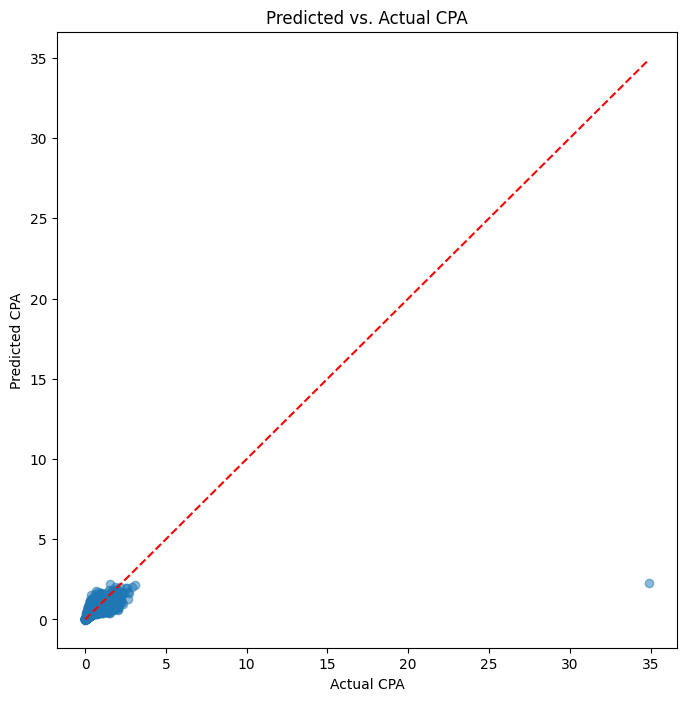

In [147]:
plot_actual_pred(y_test_raw, y_pred_raw)



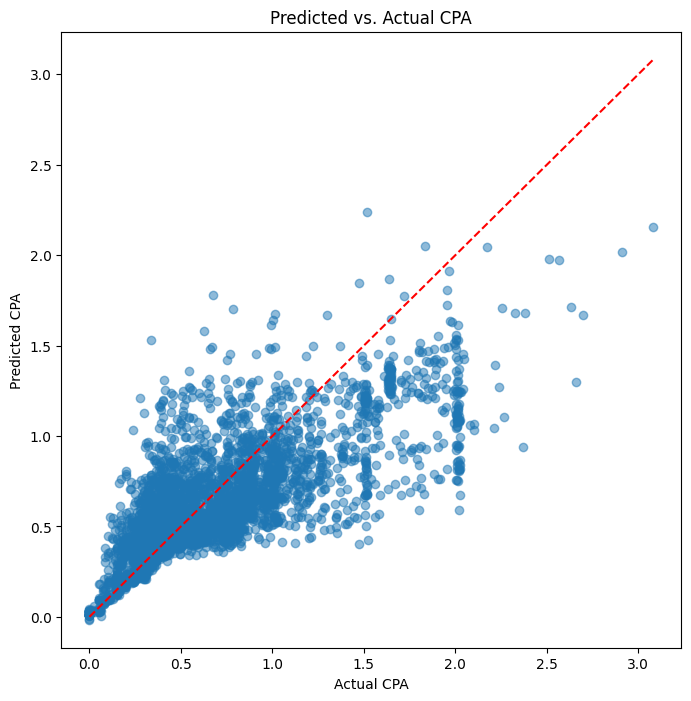

In [148]:
plot_actual_pred(y_test_raw, y_pred_raw, without_outlier=True)

There seems to be a valid relationship between the predicted values and the actual values for CPA, though there is some error still. 

Let's take a quick look at some metrics instead to better understand the performance of the model.

## Evaluation

In [149]:

from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

# Create dataclass to hold the performance metrics
@dataclass
class PerformanceMetrics:
    mae: float
    rmse: float
    r2: float

# Set function to return the metrics
def get_performance_metrics(y_pred: np.ndarray, y_true: pd.Series) -> PerformanceMetrics:

    return PerformanceMetrics(
        mae = mean_absolute_error(y_true=y_true, y_pred=y_pred),
        rmse= root_mean_squared_error(y_true=y_true, y_pred=y_pred),
        r2 = r2_score(y_true=y_true, y_pred=y_pred),
    )

metrics = get_performance_metrics(y_pred=y_pred_raw, y_true=y_test_raw)
metrics

PerformanceMetrics(mae=0.15549429726974995, rmse=0.483136400825127, r2=0.31704268476026154)

### Metric Report:

- The **R2** (R Squared) seems to be around **32%**. This means that **32%** of the variance in the $ CPA $ is explained by our model. It also implies that external factors (like market conditions, temporal data, competition, etc.) could be influencing CPA more than the model can account for. Still, the R2 is not horrible but there is certainly room for improvement. 
- The **RMSE** (Root Mean Squared Error) is **0.48**, which means that the model's average prediction can be off by about **48 cents**. For $ CPA $ this metric is critical because it gives out the typical error in the predictions. In this context, I believe minimizing the *RMSE* is a priority because it minimizes how off from the actual value we are on average.
- The **MAE** (Mean Absolute Error) is **0.15**. On average the model is off by **15 cents**. This is different from the above metrics because MAE treats all errors equally, meaning it does not give extra weight to larger errors as RMSE does. Therefore, MAE provides a more straightforward measure of the average magnitude of the errors in the predictions, without penalizing larger errors more heavily.

**Conclusion**

- We can use **MAE** when we care about consistently model the predictions close to the actual CPA, without big differences in estimates.
- We can use **RMSE** if we want to avoid larger errors, since these might cause **overspending** on some campaigns, and **underfunding** others.

In the end, I believe the minimization of **RSME** is what we should focus on because larger prediction error can have a bigger impact on budget allocation for campaigns. Minimizing it means, maximizing the **ROI** (Return on Investment) by means of more efficient use of resources.

### Quantile view for Mean Absolute Error

/var/folders/2q/2wxy0p1557l8wbkj97bbw46c0000gp/T/ipykernel_65166/3326538028.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mae_per_quantile = df_eval.groupby('quantile').apply(
/var/folders/2q/2wxy0p1557l8wbkj97bbw46c0000gp/T/ipykernel_65166/3326538028.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_per_quantile = df_eval.groupby('quantile').apply(


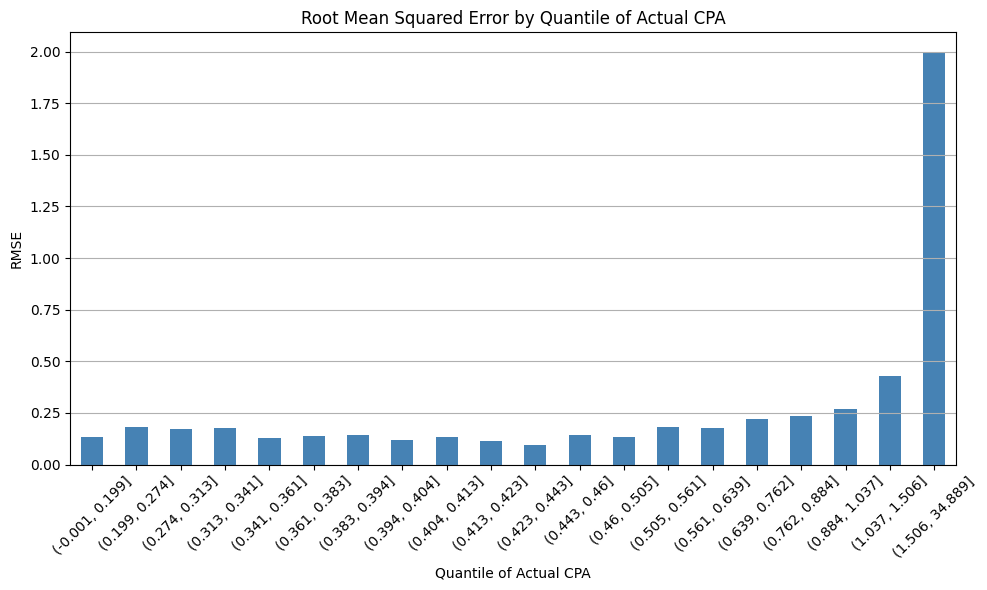

In [150]:
def plot_quantile_rmse(y_pred, y_true):
    df_eval = pd.DataFrame({
        'actual': np.ravel(y_true),
        'predicted': np.ravel(y_pred),
    })
    # Create quantile bins based on actual CPA
    df_eval['quantile'] = pd.qcut(df_eval['actual'], q=20, duplicates='drop')

    # Calculate MAE per quantile
    mae_per_quantile = df_eval.groupby('quantile').apply(
        lambda x: root_mean_squared_error(x['actual'], x['predicted'])
    )

    # Plot
    plt.figure(figsize=(10, 6))
    mae_per_quantile.plot(kind='bar', color='steelblue')
    plt.title('Root Mean Squared Error by Quantile of Actual CPA')
    plt.ylabel('RMSE')
    plt.xlabel('Quantile of Actual CPA')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_quantile_rmse(y_pred_raw, y_test_raw)

Okay this is quite interesting. It basically says that the RMSE is actually not that bad (around **\$0.15**) for $ CPA < 1 $. If $ CPA > 1 $ is something that generally is not normal we can still use this information to better use the model. In other works the model is better at predicting for lower CPA ($ CPA < 1 $) than it is for larger CPA. 

Let's take a look at the distribution of the original CPA.

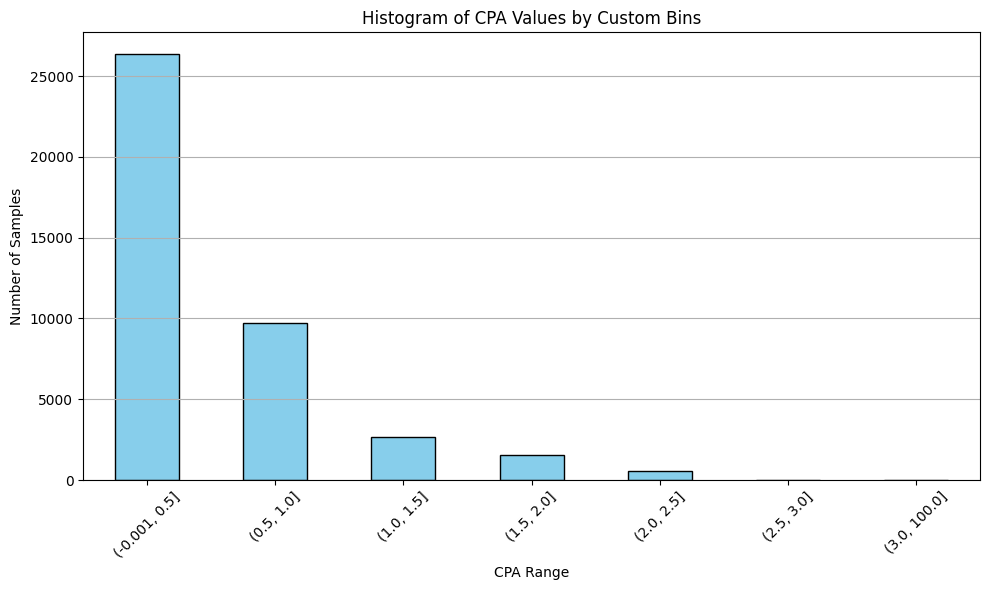

In [161]:
def histogram_cpa_by_custom_bins(y_true, bins=None):
    df = pd.DataFrame({'actual': np.ravel(y_true)})

    # Define default bins if none are provided
    if bins is None:
        bins = [0, 1, 2, 5, 10, 15, 20, 50]

    # Cut the data into the defined bins
    df['bin'] = pd.cut(df['actual'], bins=bins, include_lowest=True)

    # Count values in each bin
    bin_counts = df['bin'].value_counts().sort_index()

    # Plot histogram using custom bins
    plt.figure(figsize=(10, 6))
    bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Histogram of CPA Values by Custom Bins')
    plt.xlabel('CPA Range')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

histogram_cpa_by_custom_bins(df.CPA, bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 100])

Like we have seen before, CPA is mostly concentrated **below $1**. This is quite interesting. 

We known that, from historical data,  that most campaigns will have a *CPA* lower than **$1**, and generally the model performs better in these conditions. Therefore, when we are creating a new campaign, if the predicted CPA is low (below $1) we have, at least, a bit more information that the prediction is close to the actual value.

### Feature Importance

Like I said before, **XGBoost** has included a cool feature importance capability. Let's take a quick look at them.

In [152]:
def get_feature_names_from_column_transformer(ct):
    feature_names = []
    for name, transformer, columns in ct.transformers_:
        if transformer == 'drop':
            continue
        elif transformer == 'passthrough':
            feature_names.extend(columns)
        elif hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(columns)
            feature_names.extend(names)
        else:
            # fallback
            feature_names.extend(columns)
    return feature_names

def plot_importances(pipeline):
    # Get the model from the pipeline
    xgb_model = pipeline.named_steps["model"]

    importances = xgb_model.feature_importances_

    preprocessor = pipeline.named_steps['preprocessor']
    
    feature_names = get_feature_names_from_column_transformer(preprocessor)

    feat_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 6))
    feat_imp_df.head(20).plot(kind='barh', x='feature', y='importance', legend=False, color='teal')
    plt.title("Top 20 Feature Importances from XGBoost")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

<Figure size 1000x600 with 0 Axes>

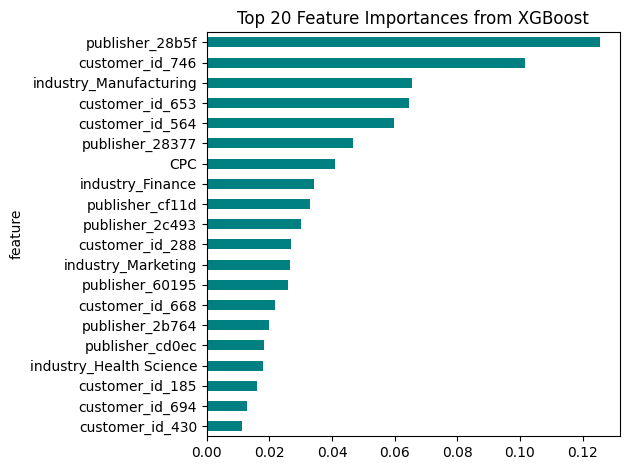

In [153]:
plot_importances(pipeline)

### Shap Values

Shap is quite useful in business context because it tells us the feature importance of the target variable in its native units. In other words, we can check how each feature contributes to each individual prediction **in actual Dollars of CPA**.

This is **quite different** form the normal feature importances (above) which mainly tells us how important a feature is in deciding how to split the data and predict CPA. Nothing specifically for business.

In [154]:
import shap

model = pipeline.named_steps["model"]
preprocessor = pipeline.named_steps["preprocessor"]

transformed_X_train = preprocessor.transform(X_train)

feature_names = get_feature_names_from_column_transformer(preprocessor)

# TreeExplainer works natively with XGBoost
explainer = shap.Explainer(model)

# Compute SHAP values for the training data
shap_values = explainer(transformed_X_train)
shap_values.feature_names = feature_names


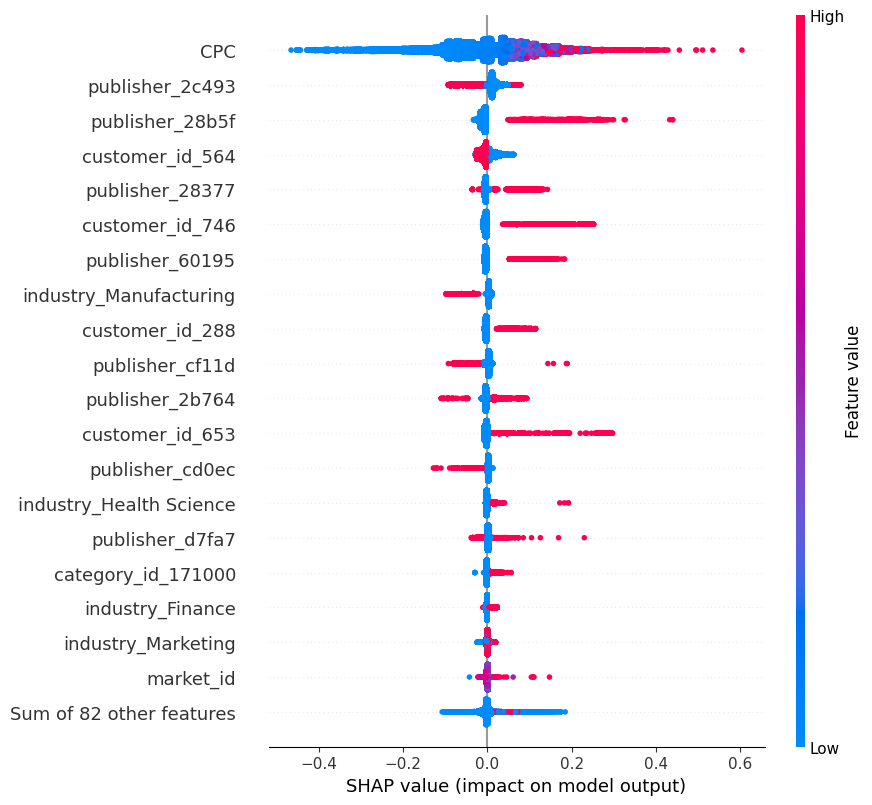

In [155]:
shap.plots.beeswarm(shap_values, max_display=20)

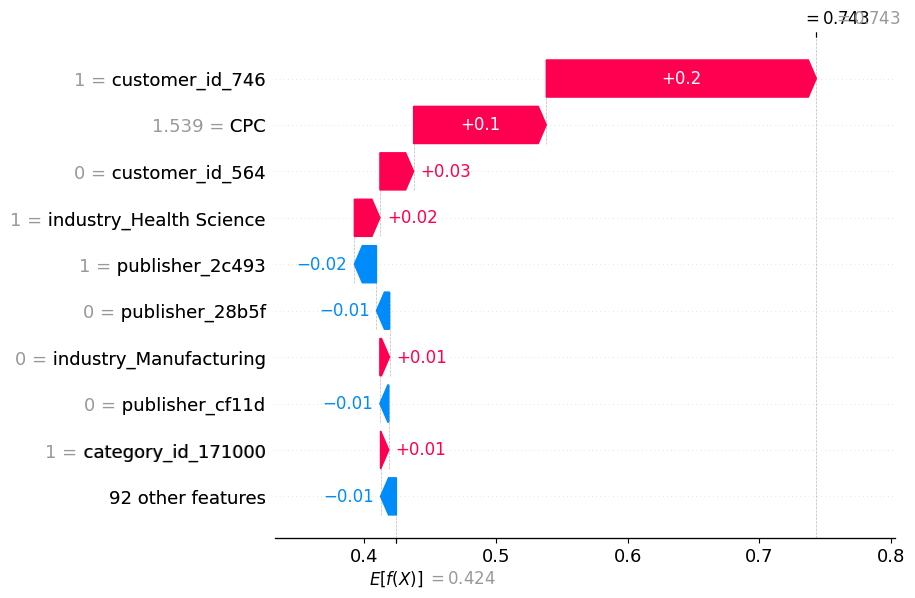

In [156]:
# Explain a single job ad / campaign prediction
shap.plots.waterfall(shap_values[0])

What we can see from the above plots is how each feature is actively responsible for lowering or increasing the *CPA* and by how much!

## Saving the Model

In [111]:
import joblib

joblib.dump(pipeline, "../resources/models/cpa_regressor.joblib")

['../resources/models/cpa_regressor.joblib']

## Future Work (CPA Prediction)

There are quite a few things that, given the time, I would have liked to improve and test. 

- **Additional Features**

Adding more features to help the model explain more of the variance, such as, temporal information (e.g. day of the week) and publisher average audience, and so on.

- **Tuning the model or other models**

This model is okay as a first model, but trying other types of models (neural nets) or tuning the model diferently and getting the best parameters (e.g. using hyperopt) could help increase the model's accuracy.

- **Hurdle Model**

Two staged model to answer two questions:
 
1. The first model will answer: *What is the probability of this campaign generating at least one conversion?*
2. The second model will answer: *Knowing that we will have at least one conversions, what will the CPA be?*


# Task 2 - Decision Making Algorithm

The purpose of this algorithm is to identify the optimal combination of market and publisher for a given customer, industry, and category, based on historical data. The algorithm predicts the Cost Per Application (CPA) for each combination of market and publisher and selects the one with the lowest CPA.

### How the Algorithm Works

1. **Data Loading**: The algorithm loads historical data and a pre-trained model from specified paths.
   
2. **Generate All Combinations**: The algorithm generates all possible combinations of historical market IDs and publisher IDs.

3. **Add Customer-Specific Features**: The customer-specific features (such as customer ID, industry, category ID, and CPC) are added to each combination.

4. **Predict CPA**: The pre-trained model is used to predict the CPA for each market-publisher combination, given the customer-specific features.

5. **Sort by CPA**: The combinations are sorted by the predicted CPA in ascending order, with the lowest CPA at the top.

6. **Return Best Combination**: The combination with the lowest CPA is returned as the best choice, consisting of the market ID, publisher, and predicted CPA.

### Output

The algorithm returns an object that contains the best market ID, the best publisher, and the predicted CPA for the selected combination.


In [212]:
from pathlib import Path
import itertools
import pandas as pd
import joblib
from dataclasses import dataclass
from utils import read_historical_data


@dataclass
class AlgoChoice:
    market_id: str
    publisher: str
    CPA: float

class DecisionAlgorithm:
    def __init__(self, historical_data_path: Path | str, model_path: Path | str):
        self.historical_data_path = historical_data_path
        self.historical_data = read_historical_data(historical_data_path)
        self.model = joblib.load(model_path)
        self.all_markets = list(self.historical_data.market_id.unique()) # Gets all historical markets
        self.all_publishers = list(self.historical_data.publisher.unique()) # Gets all historical publishers

    def get_best(self, customer_id: str, industry: str, category_id: str, CPC: float) -> pd.DataFrame:
        """Gets the best market_id and publisher given a specific list of features.
        This function will predict the CPA for all combinations of markets and publishers, along with the given
        features and return the one with a market_id and publisher with the least CPA possible.

        Args:
            customer_id (str): The ID of the customer
            industry (str): The industry of the customer
            category_id (str): The category id
            CPC (float): The highest Cost Per Click we are willing to pay

        Returns:
            pd.DataFrame: The AlgoChoice with publisher and market id
        """

        # Gets all combinations of historical markets and publishers
        combinations =  list(itertools.product(self.all_markets, self.all_publishers))

        # Makes it as a dataframe
        df = pd.DataFrame(combinations, columns=["market_id", "publisher"])

        # Adds the fixes values for customer, industry, category
        df["customer_id"] = customer_id
        df["industry"] = industry
        df["category_id"] = category_id
        df["CPC"] = CPC
        df["CPA"] = self.model.predict(df) # predicts all the CPA for all possible combinations.

        display(df)
        
        # Sorting the dataframe by CPA, where the lowest CPA sits on top
        df = df.sort_values(by="CPA", ascending=True)



        # Gets the best market_id and publisher
        best_market_id = df.iloc[0].market_id
        best_publisher = df.iloc[0].publisher
        best_cpa = float(df.iloc[0].CPA)

        # Returns the choice
        return AlgoChoice(
            market_id=best_market_id,
            publisher=best_publisher,
            CPA = best_cpa
        )

In [213]:
# Initializing the algorithm class
algo = DecisionAlgorithm(
    historical_data_path="../resources/data/ds_challenge_data.csv", 
    model_path="../resources/models/cpa_regressor.joblib"
    )

In [214]:
# Check an example
algo.get_best(
    customer_id="668",
    industry="Health Science",
    category_id="291060",
    CPC= 1
)

,market_id,publisher,customer_id,industry,category_id,CPC,CPA
0,12733593,2c493,668,Health Science,291060,1,0.399016
1,12733593,cd0ec,668,Health Science,291060,1,0.417388
2,12733593,d7fa7,668,Health Science,291060,1,0.423017
3,12733593,2b764,668,Health Science,291060,1,0.436612
4,12733593,28377,668,Health Science,291060,1,0.524125
...,...,...,...,...,...,...,...
48271,12700457,6c81d,668,Health Science,291060,1,0.528885
48272,12700457,b9650,668,Health Science,291060,1,0.431642
48273,12700457,c91cc,668,Health Science,291060,1,0.431642
48274,12700457,896ad,668,Health Science,291060,1,0.431642


AlgoChoice(market_id='12698066', publisher='2c493', CPA=0.3982020616531372)

In [125]:
# Change it to finance industry
algo.get_best(
    customer_id="668",
    industry="Finance",
    category_id="291060",
    CPC= 1
)

AlgoChoice(market_id='12739809', publisher='cf11d', CPA=0.4176207184791565)

In [126]:
# New ID
algo.get_best(
    customer_id="my_new_id",
    industry="Health Science",
    category_id="291060",
    CPC= 1
)

AlgoChoice(market_id='12698066', publisher='2c493', CPA=0.4243285059928894)

In [127]:
# Change the CPC
algo.get_best(
    customer_id="668",
    industry="Health Science",
    category_id="291060",
    CPC= 0.7
)

AlgoChoice(market_id='12763517', publisher='d7fa7', CPA=0.3013424277305603)

**CPA Efficiency**

- Highly dependant on CPA Prediction Accuracy
- Dependent on prediction speed and availability
- Retraining when model drift

**Performance Trade-Offs**

- #Predictions <-> Cost/Latency
- Model Complexity <-> Latency

**Implicit Constraints**

1. Limited to different markets and publishers available in historical data
2. Limited by the actual accuracy of the model
3. External Factors (economic situation,  market dynamics)
4. Data

**What if we have a new customer_id, industry or category_id?**

When one of these features is new (non existing in the trained model). It will of course have an impact. Although, the model is able to handle missing values on its own. 

- *One-Hot Encoding* (The transformer will provide all possible categories as "0" (zero))
- *TargetEncoder* (The transformer will provide the new *market_id* with the global average of the trained CPA.)

For example:

Assume we have 3 industries in training phase: ("Health Science", "Finance" and "Marketing").

Normally when i want to predict something for Health Science it will be encoded as a vector of **[1, 0, 0]**, indicating that we have 1 in "Health Science". 

In the case where we have a new industry: "Manufacturing", then the vector will look like **[0, 0, 0]** indicating that we have no available category and the model will still infer a CPA.